# Exploring Pipelines and Wrapping Up Phase 3

## Why Pipeline?

Pipelines can keep our code neat and clean all the way from gathering & cleaning our data, to creating models & fine-tuning them!

**Advantages**: 
- Reduces complexity
- Convenient 
- Flexible 
- Can help prevent mistakes (like data leakage between train and test set) 

Easily integrate transformers and estimators, plus cross validation!

<img src="images/grid_search_cross_validation.png" alt="cross validation image from sklearn's documentation" width=500>

Why might CV be good in instances when we're doing things like searching for optimal hyperparameters...?

- 


In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix

import category_encoders as ce

In [2]:
# May need to install category_encoders if you'd like to use it:
# !conda install -c conda-forge category_encoders

In [3]:
def evaluate(estimator, X_train, X_test, y_train, y_test):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds)}")
    print(f"ROC-AUC: {roc_auc_score(y_train, train_preds)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds)}")
    print(f"ROC-AUC: {roc_auc_score(y_test, test_preds)}")
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test)
    plt.show()

Data source: https://www.kaggle.com/c/cat-in-the-dat-ii

In [4]:
# Grab, then explore data
df = pd.read_csv('data/cat_in_the_dat2_train.csv', index_col='id')

In [5]:
df.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bin_0   582106 non-null  float64
 1   bin_1   581997 non-null  float64
 2   bin_2   582070 non-null  float64
 3   bin_3   581986 non-null  object 
 4   bin_4   581953 non-null  object 
 5   nom_0   581748 non-null  object 
 6   nom_1   581844 non-null  object 
 7   nom_2   581965 non-null  object 
 8   nom_3   581879 non-null  object 
 9   nom_4   581965 non-null  object 
 10  nom_5   582222 non-null  object 
 11  nom_6   581869 non-null  object 
 12  nom_7   581997 non-null  object 
 13  nom_8   582245 non-null  object 
 14  nom_9   581927 non-null  object 
 15  ord_0   581712 non-null  float64
 16  ord_1   581959 non-null  object 
 17  ord_2   581925 non-null  object 
 18  ord_3   582084 non-null  object 
 19  ord_4   582070 non-null  object 
 20  ord_5   582287 non-null  object 
 21  day     58

In [7]:
# Exploring numeric cols
df.describe()

,bin_0,bin_1,bin_2,ord_0,day,month,target
count,582106.000000,581997.000000,582070.000000,581712.000000,582048.000000,582012.000000,600000.000000
mean,0.092301,0.185532,0.278704,1.948224,4.112767,6.371317,0.187205
std,0.289451,0.388729,0.448362,0.853904,2.034430,3.458959,0.390076
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000
50%,0.000000,0.000000,0.000000,2.000000,5.000000,6.000000,0.000000
75%,0.000000,0.000000,1.000000,3.000000,6.000000,8.000000,0.000000
max,1.000000,1.000000,1.000000,3.000000,7.000000,12.000000,1.000000


In [8]:
df['nom_0'].describe()

count     581748
unique         3
top          Red
freq      323286
Name: nom_0, dtype: object

In [9]:
# Exploring object cols
df[[c for c in df.columns if df[c].dtype == 'object']].describe()

,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_1,ord_2,ord_3,ord_4,ord_5
count,581986,581953,581748,581844,581965,581879,581965,582222,581869,581997,582245,581927,581959,581925,582084,582070,582287
unique,2,2,3,6,6,6,4,1220,1519,222,222,2218,5,6,15,26,190
top,F,N,Red,Triangle,Hamster,India,Theremin,fc8fc7e56,ea8c5e181,4ae48e857,7d7c02c57,8f3276a6e,Novice,Freezing,n,N,Fl
freq,366212,312344,323286,164190,164897,164869,308621,977,805,5035,5052,565,160597,142726,70982,39978,10562


In [10]:
df['ord_2'].unique()

array(['Hot', 'Warm', 'Freezing', 'Lava Hot', 'Cold', 'Boiling Hot', nan],
      dtype=object)

In [11]:
# Exploring target distribution
df['target'].value_counts(normalize=True)

0    0.812795
1    0.187205
Name: target, dtype: float64

In [12]:
# Define our X and y
X = df.drop(columns=['target'])
y = df['target']

# and train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

### Baseline Model

Let's find out how hard our problem is, by throwing things at it and seeing what sticks!

Biggest thing to think about - what types of columns need to be treated differently?

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [13]:
# Set up how to treat our columns

# Want to grab numeric columns
# Then grab columns with fewer than 10 unique values
# Then grab columns with more than 10, since we won't OHE those

num_cols = []
ohe_cols = []
freq_cols = []
    
for c in X.columns:
    if df[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif len(X[c].unique()) <= 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [14]:
# Check our work
print(f"Numeric: {num_cols}")
print(f"To OHE: {ohe_cols}")
print(f"To Frequency Encode: {freq_cols}")

Numeric: ['bin_0', 'bin_1', 'bin_2', 'ord_0', 'day', 'month']
To OHE: ['bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'ord_1', 'ord_2']
To Frequency Encode: ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_3', 'ord_4', 'ord_5']


In [15]:
# Now, set up the preprocessing steps for each type of col
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

ohe_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

freq_transformer = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('freq_enc', ce.CountEncoder(normalize=True,
                                 handle_unknown=0,
                                 min_group_size=0.001,
                                 min_group_name='Other'))])

In [20]:
# Put together our preprocessor using a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat_ohe', ohe_transformer, ohe_cols), 
        ('cat_freq', freq_transformer, freq_cols)])

In [21]:
X_train.shape

(450000, 23)

In [22]:
# Just out of curiosity, let's see what this looks like 
preprocessor.fit_transform(X_train).shape

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


(450000, 63)

In [27]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(class_weight='balanced'))])

clf_logreg.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['bin_0', 'bin_1', 'bin_2',
                                                   'ord_0', 'day', 'month']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                         

Train Scores
------------
Accuracy: 0.6315244444444444
F1 Score: 0.39058686895416195
ROC-AUC: 0.6309249648095567
--------------------
Test Scores
-----------
Accuracy: 0.6310866666666667
F1 Score: 0.3909037875202254
ROC-AUC: 0.6325053670054418


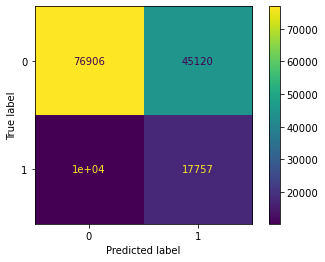

In [28]:
# Evaluate
evaluate(clf_logreg, X_train, X_test, y_train, y_test)

### Try Another Model Type

In [29]:
# Time for a new pipeline!

clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', DecisionTreeClassifier())])

clf_dt.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['bin_0', 'bin_1', 'bin_2',
                                                   'ord_0', 'day', 'month']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                         

Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
--------------------
Test Scores
-----------
Accuracy: 0.7127066666666667
F1 Score: 0.27159325242554344
ROC-AUC: 0.5487244026281379


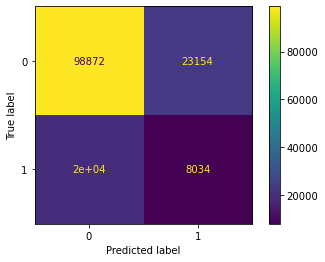

In [30]:
# Evaluate
evaluate(clf_dt, X_train, X_test, y_train, y_test)

In [31]:
num_transformer2 = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler2', StandardScaler())])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num2', num_transformer2, num_cols),
        ('cat_ohe', ohe_transformer, ohe_cols), 
        ('cat_freq', freq_transformer, freq_cols)])

clf_lr2 = Pipeline(steps=[('preprocessor2', preprocessor2),
                         ('classifier', LogisticRegression(class_weight='balanced'))])

clf_lr2.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor2',
                 ColumnTransformer(transformers=[('num2',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler2',
                                                                   StandardScaler())]),
                                                  ['bin_0', 'bin_1', 'bin_2',
                                                   'ord_0', 'day', 'month']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                    

Train Scores
------------
Accuracy: 0.6315755555555556
F1 Score: 0.39086617066225776
ROC-AUC: 0.6312072336278
--------------------
Test Scores
-----------
Accuracy: 0.6309666666666667
F1 Score: 0.3910943910943911
ROC-AUC: 0.6327071372814815


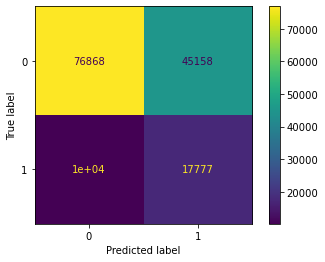

In [32]:
evaluate(clf_lr2, X_train, X_test, y_train, y_test)

In [34]:
scores = cross_val_score(clf_dt, X_train, y_train, cv=5, scoring='f1')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [35]:
print(f"Average F1 Score: {scores.mean()} +/- {scores.std()}")

Average F1 Score: 0.26934661993950515 +/- 0.002727509308701016


Adding one more piece, for the curious...

https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

In [39]:
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', DecisionTreeClassifier(class_weight='balanced'))])

In [44]:
# Parameters of pipelines can be set using ‘__’
# First part should be the name given to what piece you're adjusting,
# then second part after __ should be the name of the parameter
param_grid = {'classifier__max_depth':[10, 20, None],
              'classifier__min_samples_split':[2, 10]}

In [45]:
search = GridSearchCV(clf_dt, param_grid, n_jobs=-1, cv=3)

In [46]:
search.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['bin_0',
                                                                          'bin_1',
                                                                          'bin_2',
                                                                          'ord_0',
                                                                          

In [47]:
print(f"Best parameter's score: {search.best_score_:0.3f}):")
print(search.best_params_)

Best parameter's score: 0.722):
{'classifier__max_depth': None, 'classifier__min_samples_split': 2}


Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
--------------------
Test Scores
-----------
Accuracy: 0.7227666666666667
F1 Score: 0.2607242537910437
ROC-AUC: 0.5452503581570779


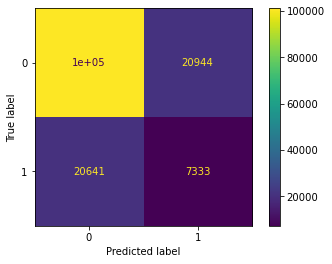

In [51]:
evaluate(search.best_estimator_, X_train, X_test, y_train, y_test)

## Discussion Time!

What does it mean to decide between model types? What do we think best represents this data? What else might I want to explore or understand before deciding that?

- 


## Resources

Check out Aurélien Geron's notebook of an [end-to-end ml project](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on his GitHub repo based around his book [_Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed)_](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)